In [23]:
# Importing Library

import math
import random
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plot
from collections import defaultdict

## Brute-force Algorithm

### Compute the average frequency of the words in the stream.

In [24]:
def brute_force(file_stream):
    word_count = defaultdict(int)
    total_words = 0
    with open(file_stream, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) < 3:
                continue
            words_stream = parts[1]
            words = words_stream.split()
            for word in words:
                word_count[word] += 1
                total_words += 1

    return word_count, total_words

word_count, total_words = brute_force('arxiv.txt')
# Sort word frequencies by frequency in descending order
word_count_sort = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

num_unique_words = len(word_count)
mean_frequency = total_words / num_unique_words

print(f"Average frequency for each word in the stream = {mean_frequency:.6f}")
print(f"With total number of words in stream = {total_words}")

Average frequency for each word in the stream = 20.076719
With total number of words in stream = 2213639


### Provide a curve plot of the word frequencies

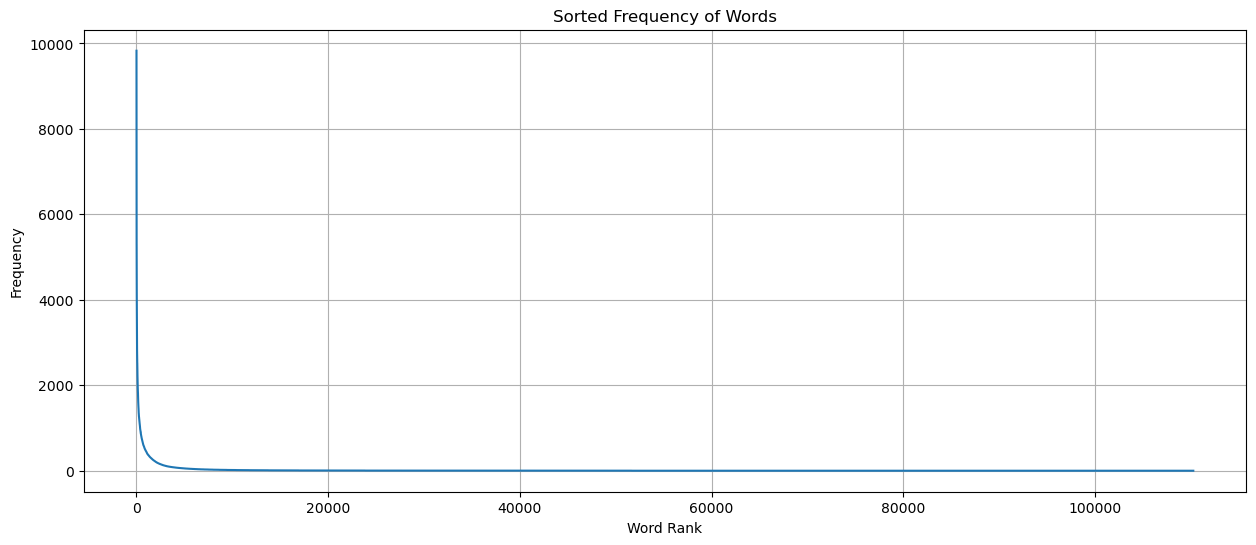

In [18]:
word, freq = zip(*word_count_sort)
plot.figure(figsize=(15, 6))
plot.plot(range(1, len(freq) + 1), freq)
plot.xlabel('Word Rank')
plot.ylabel('Frequency')
plot.title('Sorted Frequency of Words')
plot.grid(True)
plot.show()

## Reservoir Sampling

### Implement Reservoir Sampling and observe the skewness of the word distribution. Fix the sample size of words s = 10000. Estimate the word frequency from our Reservoir Summary and plot the estimated frequencies in descending order to observe the skewness.

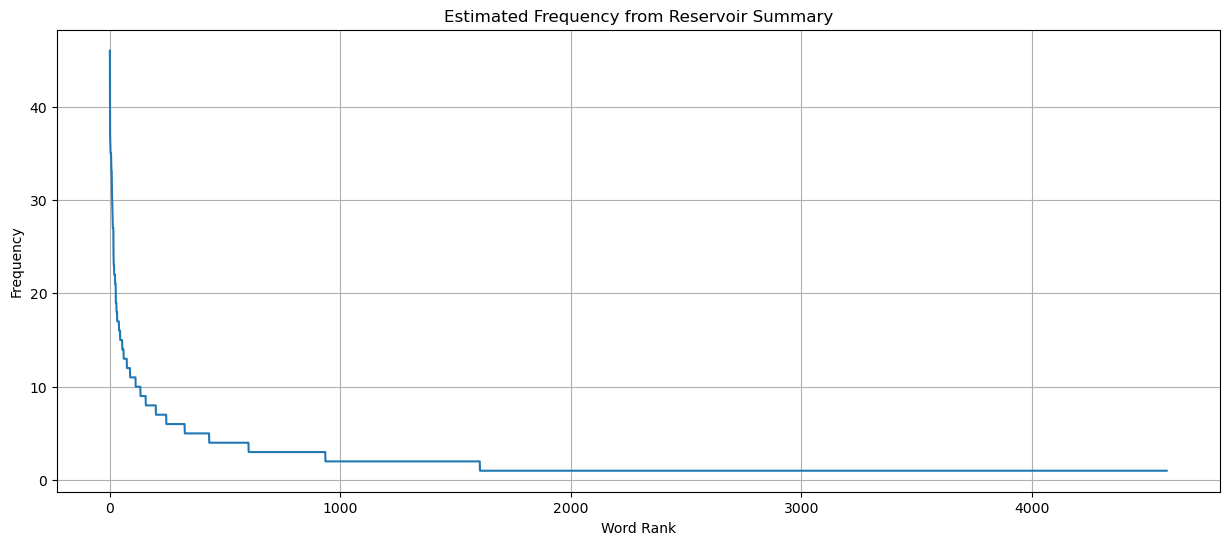

In [19]:
seed = 99

def res_sample(file_stream, s):
    reservoir = []
    word_freq = defaultdict(int)
    total_words = 0
    summary_changes = 0
    avg_summ_changes = 0
    with open(file_stream, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) < 3:
                continue
            words_stream = parts[1]
            words = words_stream.split()
            for word in words:
                total_words += 1

                if total_words <= s:
                    reservoir.append(word)
                else:
                    j = random.randint(0, total_words - 1)
                    if j < s:
                        reservoir[j] = word
                        summary_changes += 1
        avg_summ_changes += summary_changes
    
    # estimate the frequency vector from the Summary then sorted it
    for word in reservoir:
        word_freq[word] = word_freq.get(word, 0) + 1
    word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    return word_freq, avg_summ_changes

word_freq, avg_summ_changes = res_sample('arxiv.txt', 10000)
word, freq = zip(*word_freq)
plot.figure(figsize=(15, 6))
plot.plot(range(1, len(freq) + 1), freq)
plot.xlabel('Word Rank')
plot.ylabel('Frequency')
plot.title('Estimated Frequency from Reservoir Summary')
plot.grid(True)
plot.show()

 Reservoir sampling algorithm cannot accurately estimate the frequency of each data point in the stream. As we see from the frequency plot, top-1 word in Resevoir sampling ('model') only has 41 frequency compared to brute-force with frequency close to 10,000. It is because resevoir sampling did not provide probability estimation for frequency.

 However these  enables us to select a random sample from a data stream without knowing how many items are present (Vitter, 1985). This approach for selecting a representative sample of a given size k from a stream of elements is simple and effective. According to Chaudhuri et al. (1998), reservoir sampling ensures that an element has an identical chance of being present at any given time, regardless of when it initially comes in the stream. This makes it useful for tasks like generating approximate skewness in a stream that requires a representative sample.



### Run your Reservoir Sampling 5 times and report the average number of replacements over these 5 runs

In [20]:
runs =  5
for run in range(runs):
    sorted_word_freq, avg_summ_changes = res_sample('arxiv.txt', 10000)
avg_summ_changes /= runs
print(f"Average number of replacements over 5 runs = {avg_summ_changes}")


Average number of replacements over 5 runs = 10782.4


## Misra-Gries Summary

### Implement Misra-Gries summary to find the most frequent words. Please plot the estimated frequencies in descending order to observe the skewness with a summary size of k = 1000.

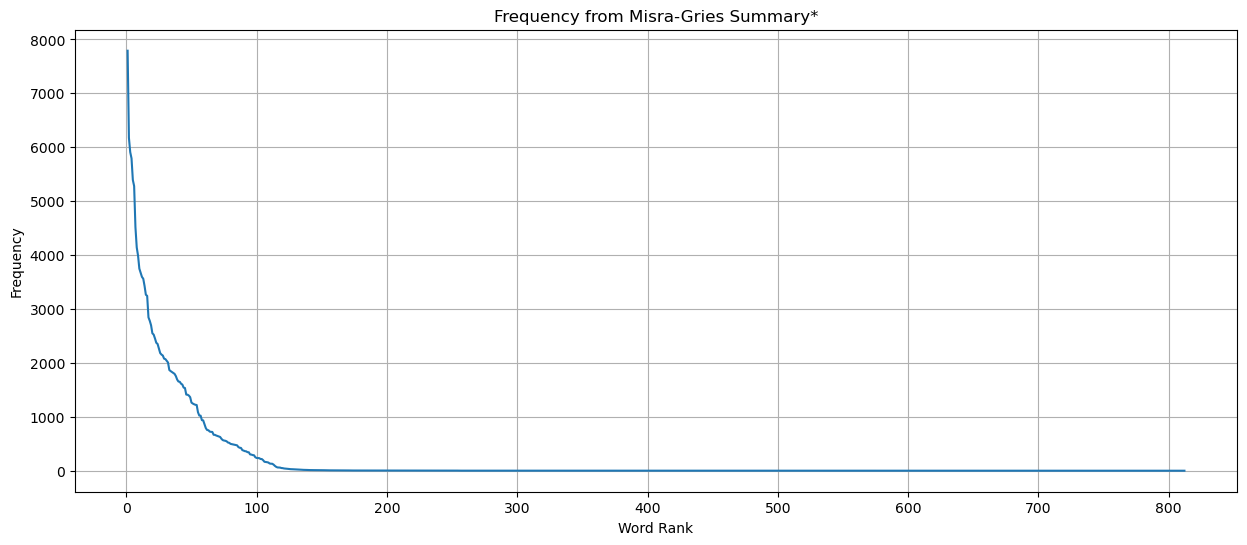

In [21]:
def MG_algo(file_stream, k):
    MG_summary = defaultdict(int)
    n_decrement = 0
    
    with open(file_stream, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) < 3:
                continue
            words_stream = parts[1]
            words = words_stream.split()
            for word in words:
                if word in MG_summary:
                    MG_summary[word] += 1
                elif len(MG_summary) < k - 1:
                    MG_summary[word] = 1
                else:
                    # Number of Decrement steps of words
                    n_decrement += 1
                    for key in list(MG_summary.keys()):
                        MG_summary[key] -= 1
                        if MG_summary[key] == 0:
                            del MG_summary[key]
                
    return MG_summary, n_decrement

k = 1000
MG_summary, n_decrement = MG_algo('arxiv.txt', k)
MG_summary_sort = sorted(MG_summary.items(), key=lambda x: x[1], reverse=True)
word, freq = zip(*MG_summary_sort)
plot.figure(figsize=(15, 6))
plot.plot(range(1, len(freq) + 1), freq)
plot.xlabel('Word Rank')
plot.ylabel('Frequency')
plot.title('Frequency from Misra-Gries Summary*')
plot.grid(True)
plot.show()

The Misra-Gries algorithm plot above showing similiar distribution but in lesser number of words keep in the summary comparing to 2213639 words from brute force. It is due to these algorithm is designed to identify the most frequent elements in a data stream, resulting in a distribution that is skewed towards these heavy hitters. It maintains a fixed number of counters to track the most frequent elements, ensuring that the top frequent elements are likely to be included, though it may miss some if the number of counters is too small.

On the other hand, Reservoir Sampling resulted to 4000-ish word and maintain the form or skewness of distribution. Because aims of these algorithm to obtain a random sample from a data stream, ensuring that each element has an equal probability of being included in the final sample. This results in a uniform distribution, providing an unbiased representation of the entire data stream. While Misra-Gries is ideal for frequency analysis and identifying frequent elements, Reservoir Sampling is best suited for obtaining a random, unbiased sample. The choice between these algorithms depends on whether the goal is to focus on frequent elements or to achieve a representative random sample.

### Investigate the impact of the size of summary k ∈ {2000,4000,6000,8000,10000} on the maximum absolute error of the Misra-Gries approach

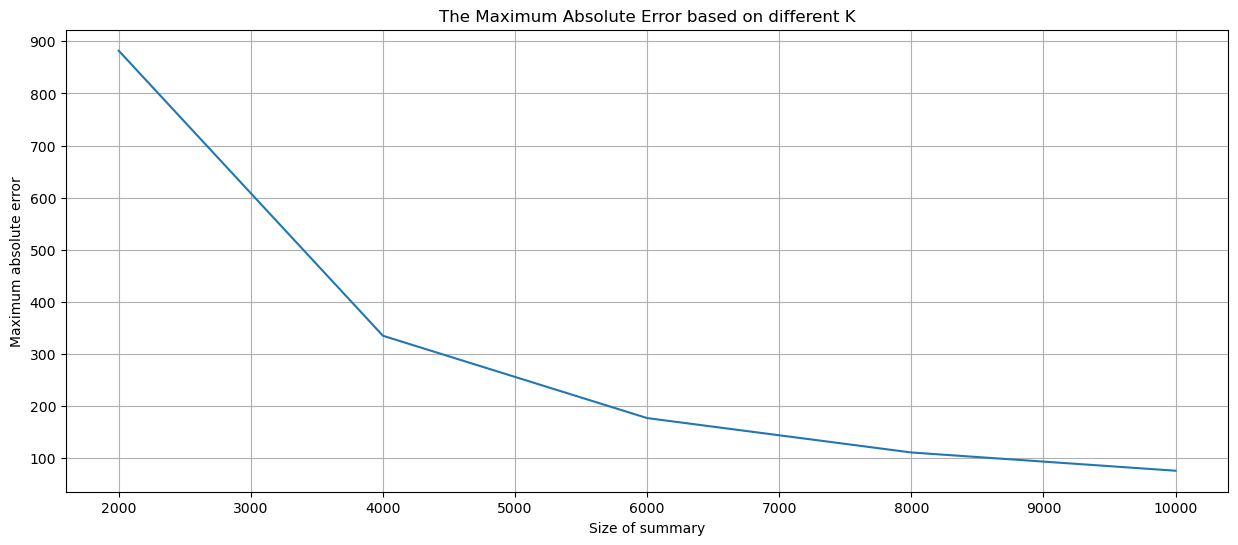

In [22]:
k = [2000, 4000, 6000, 8000, 10000]
error = np.zeros(len(k))
for i, s in enumerate(k):
    MG_summary, n_decrement = MG_algo('arxiv.txt', s)
    MG_summary_sort = sorted(MG_summary.items(), key=lambda x: x[1], reverse=True)
    word_count = dict(word_count_sort)
    MG_summary = dict(MG_summary_sort)

    for word in word_count:
        if word in MG_summary:
            curr_error = abs(MG_summary[word] - word_count[word])
            if curr_error > error[i]:
                error[i] = curr_error
               
plot.figure(figsize=(15, 6))
plot.plot(k, error)
plot.xlabel('Size of summary')
plot.ylabel('Maximum absolute error')
plot.title('The Maximum Absolute Error based on different K')
plot.grid(True)
plot.show()

The plot shows that as the size of the Mirsa-Gries summary increases, the maximum absolute error in frequency estimation decreases. This means that larger summaries can store more information about the data stream, leading to more accurate frequency estimates. This highlights the trade-off between memory usage and estimation accuracy, particularly in scenarios where accurate data representation is crucial. The plot highlights the importance of sufficient memory allocation for effective data summarization.

### If you want to find the most frequent words whose frequency is larger than 5,000. Explain how to choose the size of summary k to find these frequent words.

Misra and Gries (Cormode, 2019; Misra & Gries, 1982) defined the relationship between value and frequency above the threshold, which in this example is 5000, as threshold = N/k. N is the total number of data in the stream, and k is the size of the summary. From the brute force we know that we have 2213639  words in the stream. So to find most frequent words whose frequency is larger than 5000 as threshold is 2213639/5000. Some experts think it's advisable to find a summary size over that point for more accuracy (Cormode, 2016, 2019; Cormode & Muthukrishnan, 2004).

In [36]:
print(f"Summary size needed is at least = {(total_words/5000):.0f}")

Summary size needed is at least = 443


### Run your Misra-Gries summary with the chosen summary size in Question 3(c) and report the actual number of decrement steps calculated by your Misra-Gries.

In [37]:
k = [443, 500]
for s in k:
    MG_summary, n_decrement = MG_algo('arxiv.txt', s)
    print(f"Number of Decrement steps when max k is set on summary size = {s} is {n_decrement}")
    print(f"Actual summary used {len(MG_summary)}\n")

Number of Decrement steps when max k is set on summary size = 443 is 4934
Actual summary used 402

Number of Decrement steps when max k is set on summary size = 500 is 4348
Actual summary used 451



## CountMin Sketch

### Implement the CountMin Sketch algorithm to find the most frequent words. Please report the plot of the estimated frequencies in descending order to observe the skewness with a summary size of (w = 2000, d = 2)

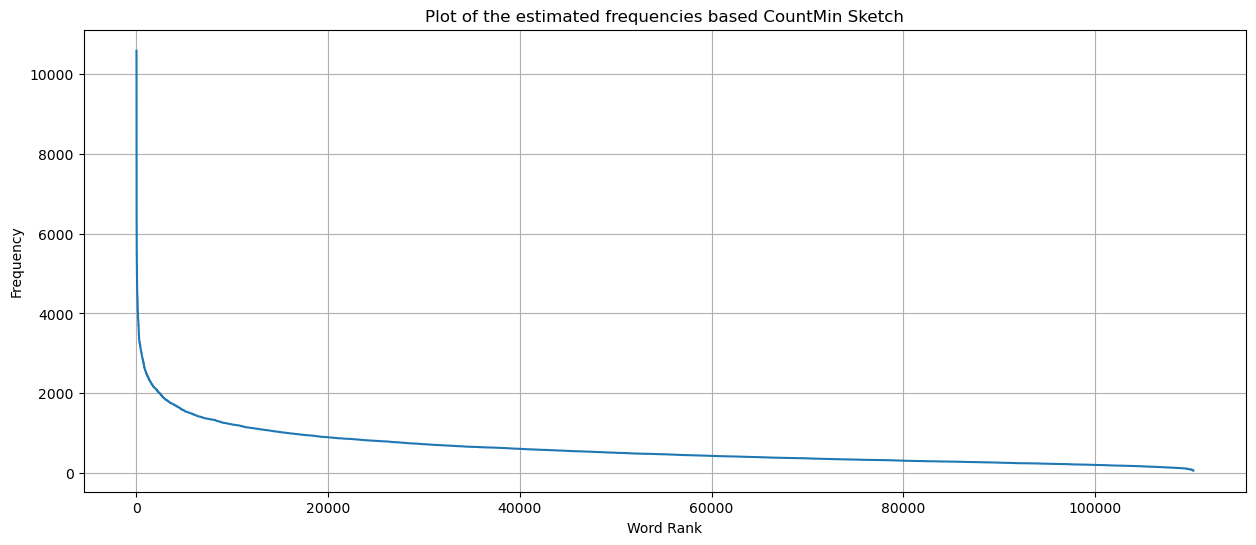

In [5]:
# initialize parameter CountMin Sketch
d = 2
w = 2000

def countmin_algo(file_stream, w, d):
    # word dectionary
    countmin_dir = defaultdict(list)
    countmin_sum = defaultdict(int)
    # Initialize matrix counter
    m_counter = np.zeros((d, w), dtype=int)
    with open(file_stream, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) < 3:
                continue
            words_stream = parts[1]
            words = words_stream.split()
            for word in words:
                # Apply hash functions to get indexes
                for i in range(d):
                    j = hash(word + str(i)) % w
                    # update counter
                    m_counter[i, j] += 1
                    if word not in countmin_dir.keys() or len(countmin_dir[word]) < d:
                        countmin_dir[word].append((i, j))
        for word in countmin_dir:
            count = float('inf')
            # get index and add
            for i, j in countmin_dir[word]:
                # get minimum counts as estimated frequency
                if m_counter[i, j] < count:
                    count = m_counter[i, j]
            countmin_sum[word] = count
    return m_counter, countmin_sum, countmin_dir

m_counter, countmin_sum, countmin_dir = countmin_algo('arxiv.txt', w, d)
countmin_sum = sorted(countmin_sum.items(), key=lambda x: x[1], reverse=True)
word, freq = zip(*countmin_sum)
plot.figure(figsize=(15, 6))
plot.plot(range(1, len(freq) + 1), freq)
plot.xlabel('Word Rank')
plot.ylabel('Frequency')
plot.title('Plot of the estimated frequencies based CountMin Sketch')
plot.grid(True)
plot.show()

With smaller size of summary needed, CountMin Sketch provide closer frequency estimation.It is because Count-Min Sketch is designed to approximate the frequency of elements in a data stream using a compact data structure with multiple hash functions. This results in a distribution that provides approximate counts with guaranteed error bounds, skewed towards frequent elements but with potential overestimation due to hash collisions (top words in CountMin is more than 10,000 compared to 9828 in Brute-force).

In contrast, the Misra-Gries algorithm focuses on identifying the most frequent elements, maintaining a fixed number of counters to track these heavy hitters, resulting in a distribution heavily skewed towards the most frequent elements. Reservoir Sampling, on the other hand, aims to obtain a random sample from the data stream, ensuring each element has an equal probability of being included, thus producing a uniform distribution. While Count-Min Sketch and Misra-Gries are both geared towards frequency analysis, with Count-Min Sketch offering approximate counts and Misra-Gries focusing on exact heavy hitters, Reservoir Sampling is best for achieving an unbiased, representative sample of the entire data stream. The choice between these algorithms depends on whether the goal is to approximate frequencies, identify frequent elements, or obtain a random sample.

### Investigate the impact of the bucket size w ∈ {2000, 4000, 6000, 8000, 10000} and d ∈ {2, 4, 8, 16} on the maximum absolute error

provide a heatmap plot of the maximum absolute error across varying w and d, with w as the x-axis and d as the y-axis.

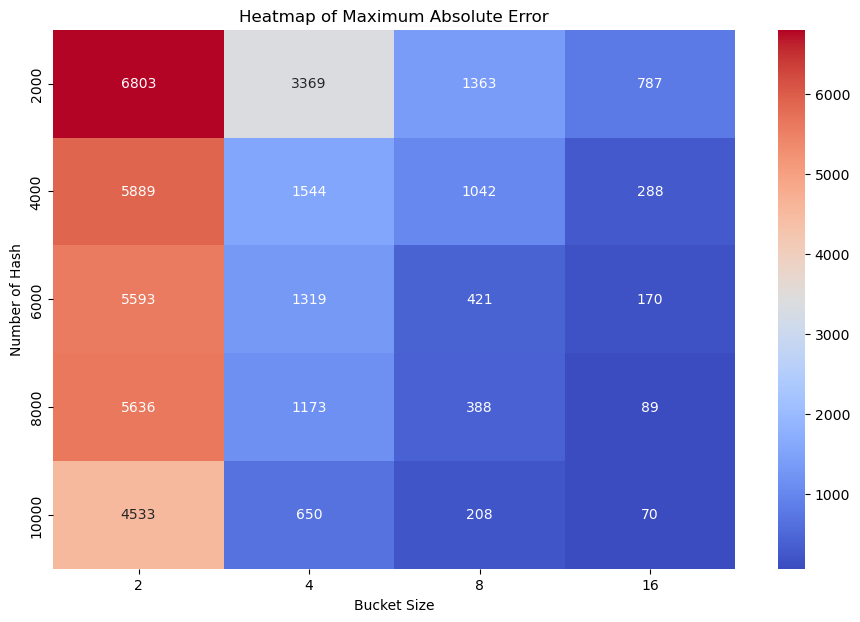

In [26]:
size_sum = [2000, 4000, 6000, 8000, 10000]
num_hash = [2, 4, 8, 16]
error = np.zeros((len(size_sum), len(num_hash)), dtype = float)
for i, w in enumerate(size_sum):
    for j, d in enumerate(num_hash):
        m_counter, countmin_sum, countmin_dir = countmin_algo('arxiv.txt', w, d)
        for word in countmin_sum:
            curr_error = abs(countmin_sum[word] - word_count[word])
            if curr_error > error[i, j]:
                error[i, j] = curr_error

plot.figure(figsize = (11, 7))
sb.heatmap(error, xticklabels = num_hash, yticklabels = size_sum, annot = True, fmt=".0f", cmap = 'coolwarm')
plot.xlabel('Bucket Size')
plot.ylabel('Number of Hash')
plot.title('Heatmap of Maximum Absolute Error')
plot.show()

Heatmap above showing that larger Bucket Size and Number of Hash resulting in lower Maximum Absolute error of the Count-Min Sketch Estimation.

### Explain how to choose the w and d such that with more than 90% probability, the absolute error of a query is at most 100.



In order to produce estimation more than 90% probability, and the absolute error of a query is at most 100.

                                        Pr[Y ≥ ϵ ⋅ m] ≤ 𝐸[𝑌] / ϵm  which  E[Y] = 𝑚/𝑤 

                                        So, Pr[Y ≥ ϵ ⋅ m] ≤ 1/w∗ϵ &  d = log(1/delta)

We have 2213639 total unique words based on Brute Force

In [35]:
epsilon = 100 / total_words

# Calculate w (number of buckets)
w = math.ceil(math.e / epsilon)
print(f"Bucket Size = {w} ~ {math.ceil(w)}")
w = math.ceil(w)

Bucket Size = 60173 ~ 60173


In [25]:
d = math.log(1/(1-0.9))
print(f"Number of hash function = {d} ~ {math.ceil(d)}")
d = math.ceil(d)

Number of hash function = 2.302585092994046 ~ 3


### Run CountMin Sketch with your chosen parameters, and report the estimate of the frequency of the words, whose frequency is above 5,000 found in the brute-force algorithm

In [40]:
# Run CountMin Sketch with w = 60173 and d = 3
m_counter, countmin_sum, countmin_dir = countmin_algo('arxiv.txt', w, d)

# get words with freq more than 5000 in brute force
top_words = [key for key, value in word_count.items() if value >= 5000]

for word in top_words:
    print(f"Estimated frequency '{word}' : {countmin_sum[word]}")

Estimated frequency 'theory' : 5787
Estimated frequency 'results' : 7949
Estimated frequency 'also' : 7834
Estimated frequency 'present' : 5602
Estimated frequency 'show' : 8220
Estimated frequency 'study' : 6029
Estimated frequency 'one' : 5303
Estimated frequency 'quantum' : 6180
Estimated frequency 'two' : 7434
Estimated frequency 'model' : 9832
Estimated frequency 'using' : 5635
Estimated frequency 'field' : 7324
Estimated frequency 'system' : 5283
Estimated frequency 'data' : 5710
Estimated frequency 'energy' : 6561
Estimated frequency 'mass' : 5466
